<a href="https://colab.research.google.com/github/yeomko22/ALS_implementation/blob/master/week18_deeplearning_cv/ch18_8_image_search_part_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ch18_8. image search part 3.

이번 챕터에서는 fine-tuning한 image classification 모델을 이용해서 추출한 embedding vector를 vector database에 저장하고, 쿼리하는 방법에 대해서 알아보겠습니다.

## 데이터 셋 준비

In [85]:
!unzip "./drive/MyDrive/2023 데이터 분석 및 시각화 취업 과정/shoes.zip" -d "/content"

Streaming output truncated to the last 5000 lines.
  inflating: /content/__MACOSX/shoes/val/boots_ankle/._000924.jpg  
  inflating: /content/shoes/val/boots_ankle/000717.jpg  
  inflating: /content/__MACOSX/shoes/val/boots_ankle/._000717.jpg  
  inflating: /content/shoes/val/boots_ankle/000071.jpg  
  inflating: /content/__MACOSX/shoes/val/boots_ankle/._000071.jpg  
  inflating: /content/shoes/val/boots_ankle/000065.jpg  
  inflating: /content/__MACOSX/shoes/val/boots_ankle/._000065.jpg  
  inflating: /content/shoes/val/boots_ankle/000703.jpg  
  inflating: /content/__MACOSX/shoes/val/boots_ankle/._000703.jpg  
  inflating: /content/shoes/val/boots_ankle/000059.jpg  
  inflating: /content/__MACOSX/shoes/val/boots_ankle/._000059.jpg  
  inflating: /content/shoes/val/boots_ankle/000298.jpg  
  inflating: /content/__MACOSX/shoes/val/boots_ankle/._000298.jpg  
  inflating: /content/shoes/val/boots_ankle/000273.jpg  
  inflating: /content/__MACOSX/shoes/val/boots_ankle/._000273.jpg  
  infl

## Vector Database

vector database는 벡터 데이터를 저장하고, 쿼리할 수 있는 기능을 제공하는 데이터 베이스입니다. 다양한 솔루션들이 있지만 그중에서 우리는 무료로 사용할 수 있고, 쉽게 배울 수 있는 pinecone을 사용해보겠습니다.

먼저 pinecone 사이트에 접속하신 다음, 회원 가입을 진행해주세요.  
pinecone: https://www.pinecone.io/

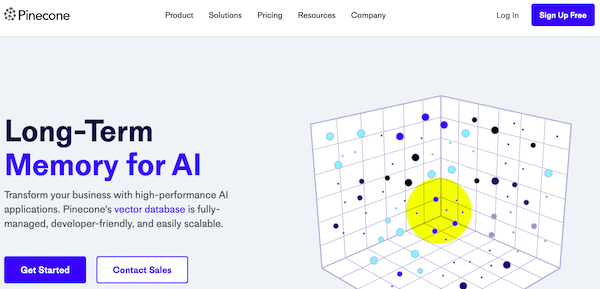

그 다음 Create Index 버튼을 눌러서 데이터를 저장할 인덱스를 생성해주세요.

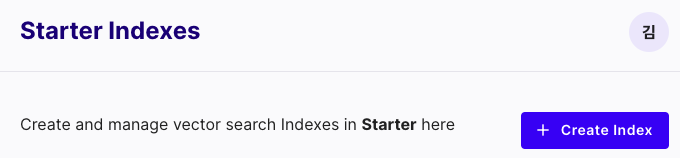

인덱스 이름과 벡터의 차원, 그리고 무료 플랜을 선택해서 인덱스를 만들어줍니다.

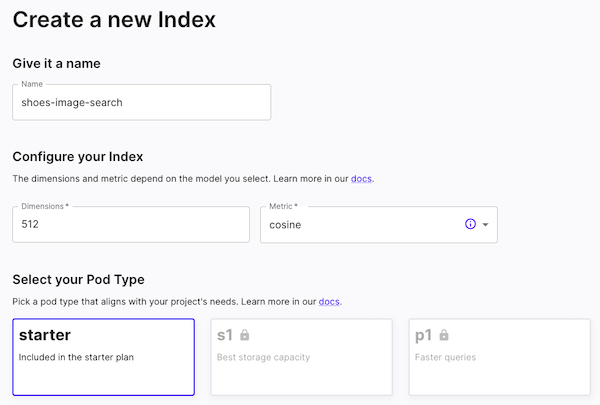

인덱스 화면에서 Connect 버튼을 눌러보면 pinecone 인덱스에 접속할 수 있는 코드를 보여줍니다.

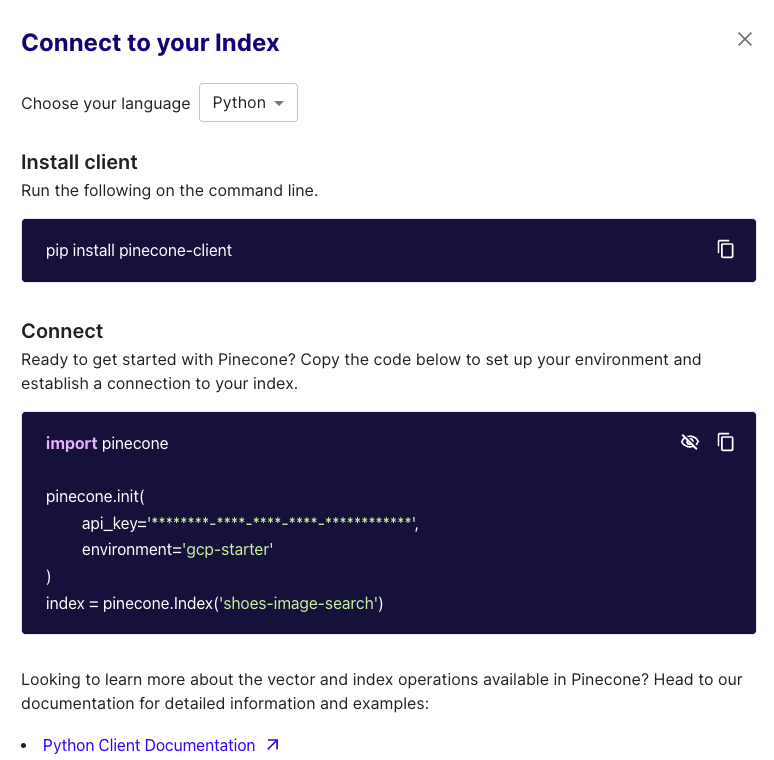

API Key 탭으로 이동하여 API key를 확인합니다.

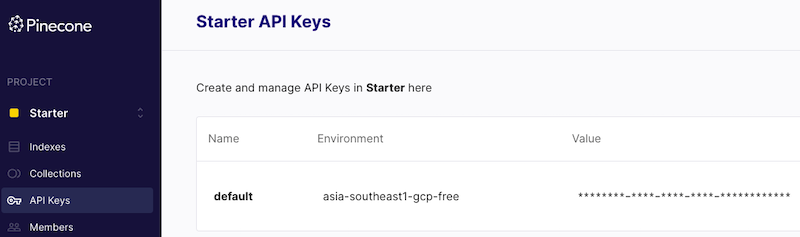

API key를 그대로 입력하는 것은 유출의 위험이 있기 때문에 getpass 라이브러리를 이용해서 pinecone api key를 입력해줍니다.

In [24]:
from getpass import getpass

pinecone_api_key = getpass('pinecone api key: ')

pinecone api key: ··········


pinecone client 라이브러리를 설치하고, 인덱스에 접속해서 현재 인덱스가 어떤 것들이 있는지 확인해보겠습니다.

In [25]:
!pip install pinecone-client

In [29]:
import pinecone

pinecone.init(
	api_key=pinecone_api_key,
	environment="gcp-starter"
)

In [30]:
pinecone.list_indexes()

['shoes-image-search']

pinecone index 객체를 생성해주겠습니다.

In [31]:
index = pinecone.Index('shoes-image-search')

## 임베딩 벡터 데이터 셋 준비

미리 뽑아놓은 임베딩 벡터 데이터 셋을 불러옵니다.

In [32]:
import pandas as pd

embedding_df = pd.read_csv("./drive/MyDrive/dscamp_2023/shoes/embeddings/resnet18_epoch_1.csv")

In [33]:
embedding_df

,path,embedding,label
0,./shoes/train/sneakers/000134.jpg,"[1.685919165611267, 2.3044610023498535, 1.7469...",11
1,./shoes/train/loafers/000876.jpg,"[2.0031189918518066, 3.850065231323242, 0.8210...",7
2,./shoes/train/boots_ankle/002920.jpg,"[0.05765902251005173, 0.039088599383831024, 1....",1
3,./shoes/train/heels/002597.jpg,"[0.11125605553388596, 0.5325693488121033, 0.11...",6
4,./shoes/train/boots_ankle/003872.jpg,"[0.16191093623638153, 1.0342309474945068, 0.97...",1
...,...,...,...
49377,./shoes/val/sneakers/002632.jpg,"[2.1719722747802734, 2.6417949199676514, 3.482...",11
49378,./shoes/val/sneakers/002633.jpg,"[2.2716145515441895, 2.3258259296417236, 2.447...",11
49379,./shoes/val/sneakers/002634.jpg,"[1.1861021518707275, 1.0263042449951172, 1.811...",11
49380,./shoes/val/sneakers/002635.jpg,"[0.7258666753768921, 0.689111053943634, 1.4118...",11


## 벡터 인덱싱

pinecone 라이브러리를 이용해서 임베딩 벡터를 인덱싱 해보겠습니다.

In [34]:
row = embedding_df.iloc[0]
embedding = eval(row["embedding"])
path = row["path"]
label = int(row["label"])
print(path, label, len(embedding))

./shoes/train/sneakers/000134.jpg 11 512


매 레코드마다 pinecone에 write 작업을 수행할 경우 시간이 오래걸립니다. batch 단위로 묶어서 데이터를 기록해보겠습니다.

In [37]:
from tqdm import tqdm

batch_size = 32
for i in tqdm(range((len(embedding_df) // batch_size) + 1)):
    batch_df = embedding_df[i*batch_size:(i+1)*batch_size]
    vectors = []
    for j in range(len(batch_df)):
        row = batch_df.iloc[j]
        id_ = row.name
        path = row["path"]
        label = int(row["label"])
        embedding = eval(row["embedding"])
        metadata = {
            "path": path,
            "label": label,
        }
        vectors.append((str(id_), embedding, metadata))
    response = index.upsert(vectors)

100%|██████████| 1544/1544 [06:25<00:00,  4.01it/s]


## 이미지 검색

이제 이미지 검색을 구현해보겠습니다. 입력 이미지가 주어지면 fine-tuning한 이미지 분류 모델을 이용해서 임베딩 벡터와 분류 결과를 뽑습니다. 그리고 이를 query로 만들어서 pinecone에 요청을 보냅니다.

### 모델 준비

In [39]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [63]:
from torchsummary import summary
from torchvision.models import resnet18, ResNet18_Weights

model = resnet18()
model.fc = torch.nn.Linear(in_features=512, out_features=12)

weight_path = "/content/drive/MyDrive/dscamp_2023/shoes/weights/resnet18_finetune_1.pth"
weight = torch.load(weight_path, map_location=device)
transform = ResNet18_Weights.IMAGENET1K_V1.transforms()

model.load_state_dict(weight)
model = model.to(device)
_ = model.eval()

In [64]:
intercepted_embeddings = []

def hook_fn(module, input, output):
    embedding = torch.flatten(output, start_dim=1).cpu().tolist()
    intercepted_embeddings.append(embedding)

model.avgpool.register_forward_hook(hook_fn)

### 이미지 준비

검색 쿼리롤 사용할 이미지를 준비합니다.

In [65]:
from PIL import Image
from matplotlib import pyplot as plt


image_dir = "./drive/MyDrive/dscamp_2023/shoes/samples"
file_names = ["example_1.jpg", "example_2.jpg", "example_3.jpg", "example_4.jpg"]
images = [Image.open(f"{image_dir}/{file_name}") for file_name in file_names]

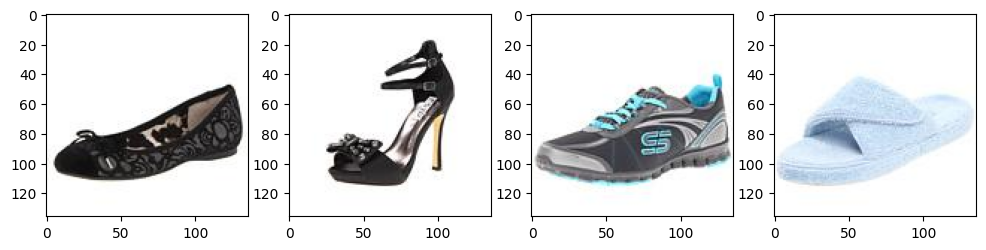

In [66]:
fig, axes = plt.subplots(1, 4, figsize=(12, 6))
for i, image in enumerate(images):
    axes[i].imshow(image)

### 인퍼런스

입력 이미지로부터 embedding vector를 추출하는 함수를 작성합니다.

In [74]:
def inference(image):
    global intercepted_embeddings

    intercepted_embeddings = []
    with torch.no_grad():
        image_tensor = transform(image)
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor.unsqueeze(0))
        probs = torch.nn.functional.softmax(outputs[0], dim=0)
        pred = torch.argmax(probs).item()
    return pred, intercepted_embeddings

In [105]:
label, embedding = inference(images[0])
print(label, embedding)

5 [[[1.2317049503326416, 1.5853937864303589, 0.022439828142523766, 0.0601637065410614, 0.0, 2.7347912788391113, 1.1372308731079102, 2.5665626525878906, 0.1814740002155304, 0.6847394108772278, 0.0005709504475817084, 2.0645618438720703, 1.041851282119751, 0.9770331382751465, 0.7199297547340393, 0.0, 1.520652413368225, 4.5010666847229, 0.0, 1.8476301431655884, 1.408158540725708, 3.520848512649536, 0.003973149694502354, 0.9654104113578796, 0.06513705849647522, 0.3379998505115509, 0.007724630646407604, 0.652830183506012, 0.49018728733062744, 0.2751838266849518, 0.16878484189510345, 1.1521143913269043, 2.100263833999634, 0.6330040097236633, 0.23705041408538818, 0.045838143676519394, 0.14529910683631897, 0.5238797664642334, 0.055695515125989914, 0.6497946381568909, 1.3981571197509766, 0.7538315057754517, 1.7755576372146606, 1.108459234237671, 0.39758241176605225, 0.24818046391010284, 0.10544370114803314, 1.6228952407836914, 0.17616356909275055, 2.246274471282959, 0.012460557743906975, 0.03663

### 검색하기

예측된 라벨과 embedding vector를 이용하여 pinecone에 검색 요청을 날리는 함수를 작성합니다.

In [106]:
def image_search(label, embedding):
    result = index.query(
        vector=embedding,
        top_k=5,
        filter={
            "label": label
        },
        include_metadata=True
    )
    return [x["metadata"]["path"] for x in result["matches"]]

In [108]:
result_paths = image_search(label=label, embedding=embedding)
print(result_paths)

['./shoes/val/flats/000000.jpg', './shoes/train/flats/000023.jpg', './shoes/train/flats/002712.jpg', './shoes/val/flats/000086.jpg', './shoes/val/flats/000286.jpg']


### 결과 시각화

In [94]:
def plot_results(result_paths):
    fig, axes = plt.subplots(1, 5, figsize=(12, 6))
    for i, result_path in enumerate(result_paths):
        image = Image.open(result_path)
        axes[i].imshow(image)

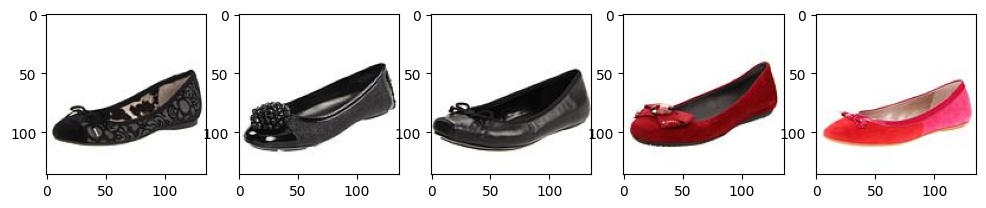

In [109]:
plot_results(result_paths)

### 샘플 데이터 셋에 대해서 이미지 검색하기

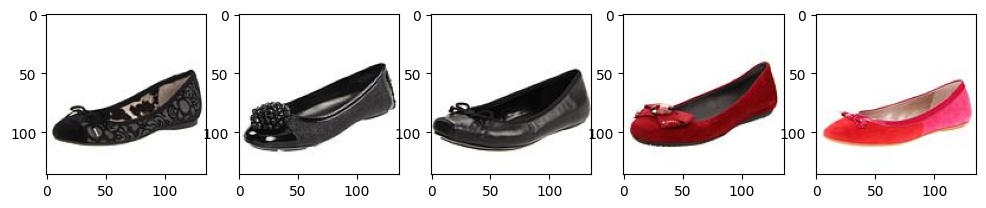

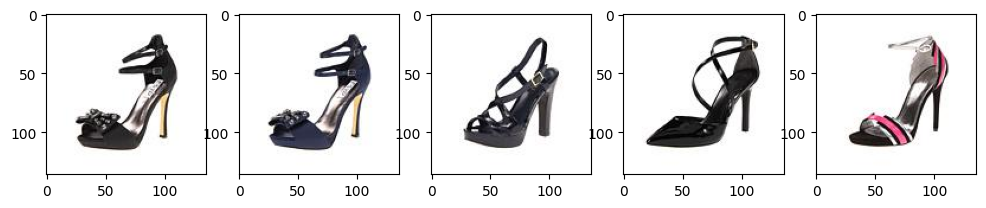

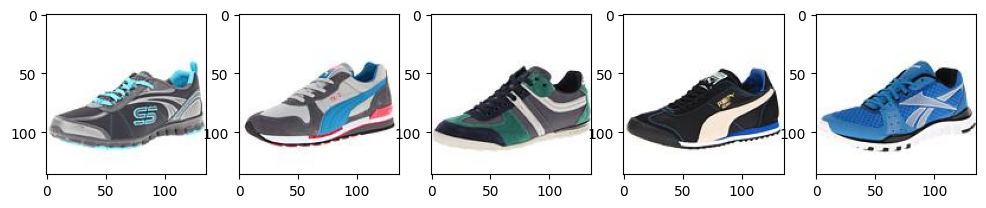

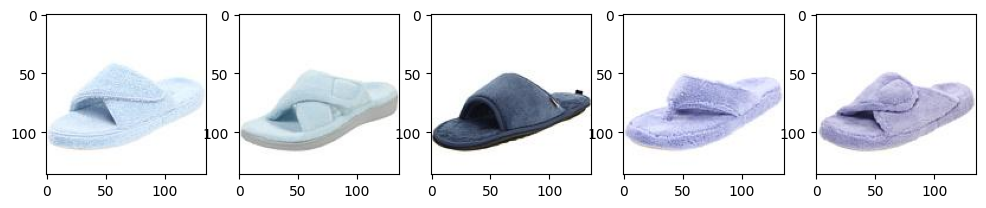

In [110]:
for i in range(4):
    query_image = images[i]
    pred, embedding = inference(query_image)
    result_paths = image_search(label=pred, embedding=embedding)
    plot_results(result_paths)

## 정리

이번 챕터에서는 벡터 데이터 베이스를 이용해서 임베딩 벡터를 저장하고, 검색하는 방법에 대해서 배워봤습니다. 그리고 fine-tuning한 이미지 분류 모델과 연결하여 이미지 검색 파이프 라인을 구성해보았습니다. 다음 챕터에서는 streamlit을 이용하여 이를 실제 웹 서비스로 구현해보도록 하겠습니다.